# Import Required Libraries

In [2]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from IPython.display import display
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard ,Callback,ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score,roc_curve, auc
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import warnings
import time
import math
warnings.filterwarnings('ignore')
from ultralytics import YOLO, __version__ as ultralytics_version
import torch
import shutil

# Define Dataset Path

 ### This cell specifies the path to the dataset configuration file.
 

In [31]:
base_dir = "D:/Project2/Project_Dataset/yolo_dataset(1)/data.yaml"

if os.path.exists(base_dir):
    print(f"Dataset configuration found at: {base_dir}")
else:
    raise FileNotFoundError(f"Dataset configuration not found at: {base_dir}")

Dataset configuration found at: D:/Project2/Project_Dataset/yolo_dataset(1)/data.yaml


# Count Images per Category

Train: 471 images, 471 labels
Val: 134 images, 134 labels
Test: 69 images, 69 labels


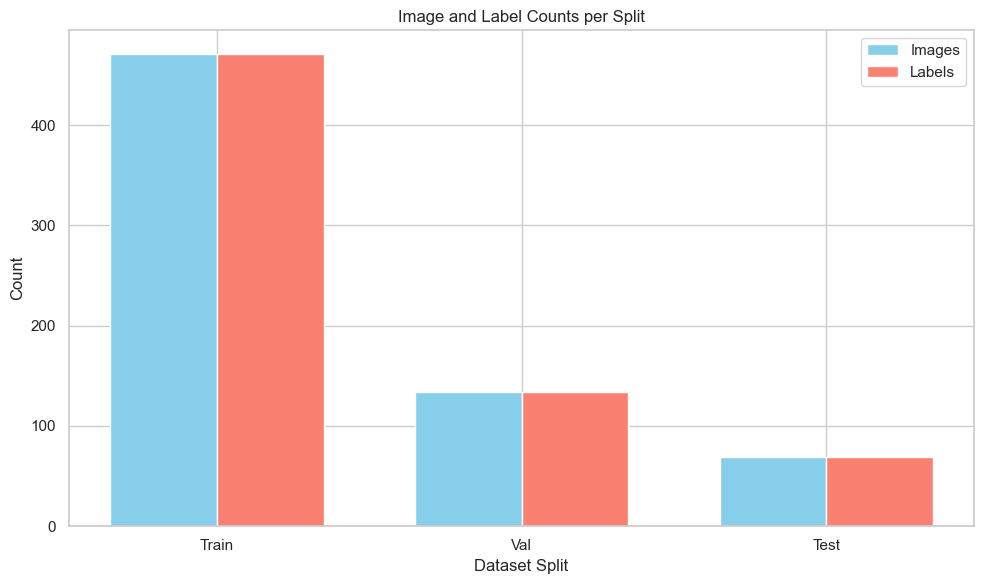

In [21]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
base_dir = r"D:\Project2\Project_Dataset\yolo_dataset(1)"
dataset_path = os.path.join(base_dir, "data.yaml")
image_extensions = ['*.jpg']
splits = []
image_counts = []
label_counts = []

for split in ['train', 'val', 'test']:
    img_dir = os.path.join(base_dir, split, 'images')
    lbl_dir = os.path.join(base_dir, split, 'labels')

    img_count = sum(len(glob.glob(os.path.join(img_dir, ext))) for ext in image_extensions)
    lbl_count = len(glob.glob(os.path.join(lbl_dir, '*.txt')))

    print(f"{split.capitalize()}: {img_count} images, {lbl_count} labels")

    splits.append(split.capitalize())
    image_counts.append(img_count)
    label_counts.append(lbl_count)
x = range(len(splits))
bar_width = 0.35

plt.bar(x, image_counts, width=bar_width, label='Images', color='skyblue')
plt.bar([p + bar_width for p in x], label_counts, width=bar_width, label='Labels', color='salmon')

plt.xlabel('Dataset Split')
plt.ylabel('Count')
plt.title('Image and Label Counts per Split')
plt.xticks([p + bar_width / 2 for p in x], splits)
plt.legend()
plt.tight_layout()
plt.show()


# Analyze Class Distribution

### This cell analyzes the distribution of object classes in the training dataset by counting the occurrences of each class in the label files.

Class Distribution in Training Set:
neutrophil: 380 instances
blast: 168 instances
artifact: 67 instances
large lymph: 78 instances
small lymph: 23 instances
monocyte: 42 instances
eosinophil: 12 instances
unknn: 22 instances
band: 5 instances
unknown: 1 instances


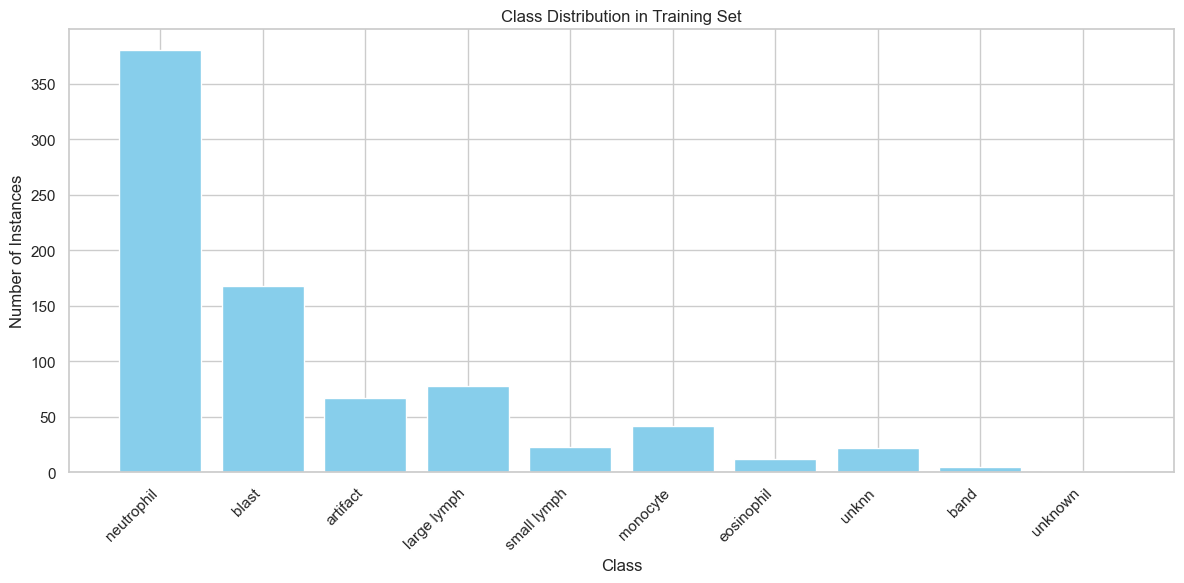

In [26]:
from collections import Counter
import yaml
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
dataset_path = r"D:\Project2\Project_Dataset\yolo_dataset(1)\data.yaml"

with open(dataset_path, 'r') as f:
    data_config = yaml.safe_load(f)
class_names = data_config['names']  

lbl_dir = os.path.join(base_dir, 'train', 'labels')
class_counts = Counter()

for txt_file in glob.glob(os.path.join(lbl_dir, '*.txt')):
    with open(txt_file, 'r') as f:
        for line in f:
            class_id = int(line.split()[0]) 
            class_counts[class_id] += 1

class_dist = {class_names[class_id]: count for class_id, count in class_counts.items()}

print("Class Distribution in Training Set:")
for class_name, count in class_dist.items():
    print(f"{class_name}: {count} instances")

plt.bar(class_dist.keys(), class_dist.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Class Distribution in Training Set')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Best Learning rate & Optimizer

In [3]:
dataset_path = r"D:\Project2\Project_Dataset\yolo_dataset(1)\data.yaml"
optimizers = ['SGD', 'Adam', 'AdamW']
learning_rates = [0.01, 0.001, 0.0001]
experiment_results = []
for optimizer in optimizers:
    for lr in learning_rates:
        print(f"\nRunning experiment with optimizer={optimizer}, lr={lr}")
        momentum = 0.937 if optimizer == 'SGD' else 0
        model = YOLO('yolov8n.yaml')

        try:
            start = time.time()
            results = model.train(
                data=dataset_path,
                epochs=3,
                batch=32,
                imgsz=640,
                lr0=lr,
                optimizer=optimizer,
                momentum=momentum,
                patience=5,
                device='cuda' if torch.cuda.is_available() else 'cpu',
                name=f'exp_{optimizer}_lr{lr}',
                verbose=False
            )

            end = time.time()
            elapsed = end - start
            metrics = results.results_dict
            experiment_results.append({
                'optimizer': optimizer,
                'learning_rate': lr,
                'mAP50': metrics['metrics/mAP50(B)'],
                'mAP50-95': metrics['metrics/mAP50-95(B)'],
                'val_loss': metrics['val/loss'],
                'train_time_sec': elapsed
            })
            shutil.rmtree(model.trainer.save_dir, ignore_errors=True)

        except Exception as e:
            print(f"Experiment failed: optimizer={optimizer}, lr={lr}, error={e}")

results_df = pd.DataFrame(experiment_results)
results_df.to_csv('experiment_results.csv', index=False)
print("\nExperiment Results:")
print(results_df)
sns.set(style="whitegrid")



Running experiment with optimizer=SGD, lr=0.01
New https://pypi.org/project/ultralytics/8.3.151 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.149  Python-3.9.21 torch-2.7.0+cpu CPU (Intel Core(TM) i5-7200U 2.50GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\Project2\Project_Dataset\yolo_dataset(1)\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=1.

train: Scanning D:\Project2\Project_Dataset\yolo_dataset(1)\train\labels.cache... 471 images, 0 backgrounds, 0 corrupt:

val: Fast image access  (ping: 0.50.3 ms, read: 266.436.8 MB/s, size: 2340.5 KB)



val: Scanning D:\Project2\Project_Dataset\yolo_dataset(1)\val\labels.cache... 134 images, 0 backgrounds, 0 corrupt: 100


Plotting labels to runs\detect\exp_SGD_lr0.01\labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\exp_SGD_lr0.01
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3         0G      4.496      6.253      4.417         60        640: 100%|██████████| 15/15 [12:10<00:00, 48.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:01<0

                   all        134        210          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3         0G      3.854      5.483      4.133         73        640: 100%|██████████| 15/15 [10:40<00:00, 42.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:53<0

                   all        134        210          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3         0G      3.261      4.719      3.691         53        640: 100%|██████████| 15/15 [10:48<00:00, 43.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:54<0

                   all        134        210          0          0          0          0



3 epochs completed in 0.611 hours.
Optimizer stripped from runs\detect\exp_SGD_lr0.01\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\exp_SGD_lr0.01\weights\best.pt, 6.2MB

Validating runs\detect\exp_SGD_lr0.01\weights\best.pt...
Ultralytics 8.3.149  Python-3.9.21 torch-2.7.0+cpu CPU (Intel Core(TM) i5-7200U 2.50GHz)
YOLOv8n summary (fused): 72 layers, 3,008,378 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:48<0


                   all        134        210          0          0          0          0
Speed: 4.6ms preprocess, 162.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\exp_SGD_lr0.01
Experiment failed: optimizer=SGD, lr=0.01, error='val/loss'

Running experiment with optimizer=SGD, lr=0.001
New https://pypi.org/project/ultralytics/8.3.151 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.149  Python-3.9.21 torch-2.7.0+cpu CPU (Intel Core(TM) i5-7200U 2.50GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\Project2\Project_Dataset\yolo_dataset(1)\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, for

train: Scanning D:\Project2\Project_Dataset\yolo_dataset(1)\train\labels.cache... 471 images, 0 backgrounds, 0 corrupt:

val: Fast image access  (ping: 0.30.1 ms, read: 891.5189.9 MB/s, size: 2340.5 KB)



val: Scanning D:\Project2\Project_Dataset\yolo_dataset(1)\val\labels.cache... 134 images, 0 backgrounds, 0 corrupt: 100


Plotting labels to runs\detect\exp_SGD_lr0.001\labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\exp_SGD_lr0.001
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3         0G      4.559      6.371      4.482         60        640: 100%|██████████| 15/15 [11:16<00:00, 45.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:55<0

                   all        134        210          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3         0G      4.244      5.962      4.171         73        640: 100%|██████████| 15/15 [10:37<00:00, 42.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:54<0

                   all        134        210          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3         0G      3.996      5.635       3.89         53        640: 100%|██████████| 15/15 [10:29<00:00, 41.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:55<0

                   all        134        210          0          0          0          0



3 epochs completed in 0.587 hours.
Optimizer stripped from runs\detect\exp_SGD_lr0.001\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\exp_SGD_lr0.001\weights\best.pt, 6.2MB

Validating runs\detect\exp_SGD_lr0.001\weights\best.pt...
Ultralytics 8.3.149  Python-3.9.21 torch-2.7.0+cpu CPU (Intel Core(TM) i5-7200U 2.50GHz)
YOLOv8n summary (fused): 72 layers, 3,008,378 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:50<0


                   all        134        210          0          0          0          0
Speed: 5.3ms preprocess, 176.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs\detect\exp_SGD_lr0.001
Experiment failed: optimizer=SGD, lr=0.001, error='val/loss'

Running experiment with optimizer=SGD, lr=0.0001
New https://pypi.org/project/ultralytics/8.3.151 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.149  Python-3.9.21 torch-2.7.0+cpu CPU (Intel Core(TM) i5-7200U 2.50GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\Project2\Project_Dataset\yolo_dataset(1)\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, 

train: Scanning D:\Project2\Project_Dataset\yolo_dataset(1)\train\labels.cache... 471 images, 0 backgrounds, 0 corrupt:

val: Fast image access  (ping: 0.20.0 ms, read: 982.249.4 MB/s, size: 2340.5 KB)



val: Scanning D:\Project2\Project_Dataset\yolo_dataset(1)\val\labels.cache... 134 images, 0 backgrounds, 0 corrupt: 100


Plotting labels to runs\detect\exp_SGD_lr0.0001\labels.jpg... 
optimizer: SGD(lr=0.0001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\exp_SGD_lr0.0001
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3         0G      4.563      6.388      4.502         60        640: 100%|██████████| 15/15 [11:05<00:00, 44.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:54<0

                   all        134        210          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3         0G      4.296      6.016      4.267         73        640: 100%|██████████| 15/15 [11:37<00:00, 46.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:54<0

                   all        134        210          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3         0G       4.15      5.778      4.025         53        640: 100%|██████████| 15/15 [10:54<00:00, 43.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:54<0

                   all        134        210          0          0          0          0



3 epochs completed in 0.607 hours.
Optimizer stripped from runs\detect\exp_SGD_lr0.0001\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\exp_SGD_lr0.0001\weights\best.pt, 6.2MB

Validating runs\detect\exp_SGD_lr0.0001\weights\best.pt...
Ultralytics 8.3.149  Python-3.9.21 torch-2.7.0+cpu CPU (Intel Core(TM) i5-7200U 2.50GHz)
YOLOv8n summary (fused): 72 layers, 3,008,378 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:49<0


                   all        134        210          0          0          0          0
Speed: 4.7ms preprocess, 167.9ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs\detect\exp_SGD_lr0.0001
Experiment failed: optimizer=SGD, lr=0.0001, error='val/loss'

Running experiment with optimizer=Adam, lr=0.01
New https://pypi.org/project/ultralytics/8.3.151 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.149  Python-3.9.21 torch-2.7.0+cpu CPU (Intel Core(TM) i5-7200U 2.50GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\Project2\Project_Dataset\yolo_dataset(1)\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0,

train: Scanning D:\Project2\Project_Dataset\yolo_dataset(1)\train\labels.cache... 471 images, 0 backgrounds, 0 corrupt:

val: Fast image access  (ping: 0.40.4 ms, read: 922.3266.2 MB/s, size: 2340.5 KB)



val: Scanning D:\Project2\Project_Dataset\yolo_dataset(1)\val\labels.cache... 134 images, 0 backgrounds, 0 corrupt: 100


Plotting labels to runs\detect\exp_Adam_lr0.01\labels.jpg... 
Experiment failed: optimizer=Adam, lr=0.01, error=betas must be either both floats or both Tensors

Running experiment with optimizer=Adam, lr=0.001
New https://pypi.org/project/ultralytics/8.3.151 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.149  Python-3.9.21 torch-2.7.0+cpu CPU (Intel Core(TM) i5-7200U 2.50GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\Project2\Project_Dataset\yolo_dataset(1)\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, i

train: Scanning D:\Project2\Project_Dataset\yolo_dataset(1)\train\labels.cache... 471 images, 0 backgrounds, 0 corrupt:

val: Fast image access  (ping: 0.20.0 ms, read: 1020.1193.9 MB/s, size: 2340.5 KB)



val: Scanning D:\Project2\Project_Dataset\yolo_dataset(1)\val\labels.cache... 134 images, 0 backgrounds, 0 corrupt: 100


Plotting labels to runs\detect\exp_Adam_lr0.001\labels.jpg... 
WARNING 
Experiment failed: optimizer=Adam, lr=0.001, error=betas must be either both floats or both Tensors

Running experiment with optimizer=Adam, lr=0.0001
New https://pypi.org/project/ultralytics/8.3.151 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.149  Python-3.9.21 torch-2.7.0+cpu CPU (Intel Core(TM) i5-7200U 2.50GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\Project2\Project_Dataset\yolo_dataset(1)\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, i

train: Scanning D:\Project2\Project_Dataset\yolo_dataset(1)\train\labels.cache... 471 images, 0 backgrounds, 0 corrupt:

val: Fast image access  (ping: 0.20.1 ms, read: 842.9169.8 MB/s, size: 2340.5 KB)



val: Scanning D:\Project2\Project_Dataset\yolo_dataset(1)\val\labels.cache... 134 images, 0 backgrounds, 0 corrupt: 100


Plotting labels to runs\detect\exp_Adam_lr0.0001\labels.jpg... 
Experiment failed: optimizer=Adam, lr=0.0001, error=betas must be either both floats or both Tensors

Running experiment with optimizer=AdamW, lr=0.01
New https://pypi.org/project/ultralytics/8.3.151 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.149  Python-3.9.21 torch-2.7.0+cpu CPU (Intel Core(TM) i5-7200U 2.50GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\Project2\Project_Dataset\yolo_dataset(1)\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=Fals

train: Scanning D:\Project2\Project_Dataset\yolo_dataset(1)\train\labels.cache... 471 images, 0 backgrounds, 0 corrupt:

val: Fast image access  (ping: 0.20.0 ms, read: 1069.4265.7 MB/s, size: 2340.5 KB)



val: Scanning D:\Project2\Project_Dataset\yolo_dataset(1)\val\labels.cache... 134 images, 0 backgrounds, 0 corrupt: 100


Plotting labels to runs\detect\exp_AdamW_lr0.01\labels.jpg... 
Experiment failed: optimizer=AdamW, lr=0.01, error=betas must be either both floats or both Tensors

Running experiment with optimizer=AdamW, lr=0.001
New https://pypi.org/project/ultralytics/8.3.151 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.149  Python-3.9.21 torch-2.7.0+cpu CPU (Intel Core(TM) i5-7200U 2.50GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\Project2\Project_Dataset\yolo_dataset(1)\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False

train: Scanning D:\Project2\Project_Dataset\yolo_dataset(1)\train\labels.cache... 471 images, 0 backgrounds, 0 corrupt:

val: Fast image access  (ping: 0.20.0 ms, read: 1037.488.2 MB/s, size: 2340.5 KB)



val: Scanning D:\Project2\Project_Dataset\yolo_dataset(1)\val\labels.cache... 134 images, 0 backgrounds, 0 corrupt: 100


Plotting labels to runs\detect\exp_AdamW_lr0.001\labels.jpg... 
Experiment failed: optimizer=AdamW, lr=0.001, error=betas must be either both floats or both Tensors

Running experiment with optimizer=AdamW, lr=0.0001
New https://pypi.org/project/ultralytics/8.3.151 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.149  Python-3.9.21 torch-2.7.0+cpu CPU (Intel Core(TM) i5-7200U 2.50GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\Project2\Project_Dataset\yolo_dataset(1)\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=Fa

train: Scanning D:\Project2\Project_Dataset\yolo_dataset(1)\train\labels.cache... 471 images, 0 backgrounds, 0 corrupt:

val: Fast image access  (ping: 0.20.0 ms, read: 1013.4106.5 MB/s, size: 2340.5 KB)



val: Scanning D:\Project2\Project_Dataset\yolo_dataset(1)\val\labels.cache... 134 images, 0 backgrounds, 0 corrupt: 100


Plotting labels to runs\detect\exp_AdamW_lr0.0001\labels.jpg... 
Experiment failed: optimizer=AdamW, lr=0.0001, error=betas must be either both floats or both Tensors

Experiment Results:
Empty DataFrame
Columns: []
Index: []


# Training model

In [5]:
from datetime import datetime

dataset_path = r"D:/Project2/Project_Dataset/yolo_dataset(1)/data.yaml"
batch_size = 16
best_lr = 0.001

model = YOLO('yolov8n.yaml')  

try:
    print(f"\n Starting training with lr={best_lr}")
    results = model.train(
        data=dataset_path,
        model='yolov8n.pt',
        epochs=100,  
        batch=batch_size,
        imgsz=640,
        lr0=best_lr,
        optimizer='SGD',   
        momentum=0.9,
        device='cpu',  
        name='yolov8n_final_cpu',
        patience=15,  
        augment=True,
        hsv_h=0.015,
        hsv_s=0.7,
        hsv_v=0.4,
        flipud=0.5,
        fliplr=0.5,
        scale=0.5,
        translate=0.1,
        mosaic=0.3,  
        mixup=0.1,   
        verbose=True
    )

    model_path = f"yolov8n_final_cpu_lr{best_lr:.0e}.pt"
    model.save(model_path)
    print(f" Model saved as {model_path}")

    final_results = {
        'Timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'mAP50': results.results_dict.get('metrics/mAP50(B)', 0),
        'mAP50-95': results.results_dict.get('metrics/mAP50-95(B)', 0),
        'Validation Loss': results.results_dict.get('val/loss', 0),
        'Box Loss': results.results_dict.get('val/box_loss', 0),
        'Cls Loss': results.results_dict.get('val/cls_loss', 0),
        'Learning Rate': best_lr,
        'Batch Size': batch_size,
        'Epochs': results.current_epoch
    }

    csv_path = "training_results.csv"
    if os.path.exists(csv_path):
        df_old = pd.read_csv(csv_path)
        df_new = pd.concat([df_old, pd.DataFrame([final_results])], ignore_index=True)
    else:
        df_new = pd.DataFrame([final_results])
    df_new.to_csv(csv_path, index=False)
    print(f" Results saved to {csv_path}")

except Exception as e:
    print(f" Training failed: {e}")


 Starting training with lr=0.001
New https://pypi.org/project/ultralytics/8.3.152 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.149  Python-3.9.21 torch-2.7.0+cpu CPU (Intel Core(TM) i5-7200U 2.50GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:/Project2/Project_Dataset/yolo_dataset(1)/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8n.pt, momentum=0.9, mosaic=0.3, multi_scale=F

train: Scanning D:\Project2\Project_Dataset\yolo_dataset(1)\train\labels.cache... 471 images, 0 backgrounds, 0 corrupt:

val: Fast image access  (ping: 0.20.0 ms, read: 1051.1152.4 MB/s, size: 2340.5 KB)



val: Scanning D:\Project2\Project_Dataset\yolo_dataset(1)\val\labels.cache... 134 images, 0 backgrounds, 0 corrupt: 100


Plotting labels to runs\detect\yolov8n_final_cpu9\labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\yolov8n_final_cpu9
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      4.141      6.538       4.49         16        640: 100%|██████████| 30/30 [09:17<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:53<0

                   all        134        210          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      3.765      6.071      4.101         21        640: 100%|██████████| 30/30 [09:09<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:53<0

                   all        134        210          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      3.357      5.733       4.01         10        640: 100%|██████████| 30/30 [09:12<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:53<0

                   all        134        210          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      3.255      5.284       3.92         18        640: 100%|██████████| 30/30 [09:13<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:39<0

                   all        134        210          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      3.091      4.991      3.789         15        640: 100%|██████████| 30/30 [09:04<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210     0.0458     0.0132     0.0254    0.00328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      2.811      4.741      3.603         11        640: 100%|██████████| 30/30 [09:19<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:01<0

                   all        134        210      0.631      0.177      0.143     0.0847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      2.488      4.458      3.381         14        640: 100%|██████████| 30/30 [09:14<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210      0.512      0.198     0.0869     0.0484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      2.196      4.294      3.112         17        640: 100%|██████████| 30/30 [09:11<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210      0.523      0.129      0.102     0.0565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      2.052      4.148      2.913         19        640: 100%|██████████| 30/30 [09:09<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210      0.524      0.132     0.0896     0.0492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      1.947      4.036       2.69         14        640: 100%|██████████| 30/30 [09:09<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210      0.437      0.217      0.108     0.0583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      1.838      4.022      2.527         28        640: 100%|██████████| 30/30 [09:10<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210      0.404       0.26     0.0925     0.0531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      1.784      3.807      2.412         14        640: 100%|██████████| 30/30 [09:07<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210      0.628      0.177      0.107     0.0618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      1.667      3.613      2.314         17        640: 100%|██████████| 30/30 [09:10<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210       0.66      0.147      0.121     0.0744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G       1.67      3.569      2.257         28        640: 100%|██████████| 30/30 [09:09<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:53<0

                   all        134        210      0.471      0.266      0.128     0.0724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      1.584      3.384      2.115         16        640: 100%|██████████| 30/30 [09:11<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210      0.641      0.215      0.115     0.0635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      1.579      3.292      2.092         21        640: 100%|██████████| 30/30 [1:11:43<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:29<0

                   all        134        210      0.523      0.219      0.117     0.0619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      1.588      3.327      2.061         22        640: 100%|██████████| 30/30 [05:11<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<0

                   all        134        210      0.638      0.215      0.127     0.0742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      1.495      3.275      1.988         15        640: 100%|██████████| 30/30 [05:10<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<0

                   all        134        210      0.651      0.248      0.158     0.0855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      1.429      3.148      1.912         16        640: 100%|██████████| 30/30 [05:11<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<0

                   all        134        210      0.763      0.174      0.167     0.0856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G        1.5       3.17      1.913         23        640: 100%|██████████| 30/30 [05:08<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<0

                   all        134        210      0.701      0.216      0.176     0.0992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G       1.44      3.034      1.895         22        640: 100%|██████████| 30/30 [05:11<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<0

                   all        134        210      0.673      0.264      0.183      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      1.387      3.029      1.831         16        640: 100%|██████████| 30/30 [05:09<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<0

                   all        134        210      0.542      0.222       0.18      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      1.396      2.965      1.835         13        640: 100%|██████████| 30/30 [05:11<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<0

                   all        134        210       0.69      0.178      0.191      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      1.412      2.977      1.817         17        640: 100%|██████████| 30/30 [05:10<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<0

                   all        134        210      0.681      0.224      0.205       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G      1.353       2.98      1.772         21        640: 100%|██████████| 30/30 [05:18<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<0

                   all        134        210      0.685      0.253      0.198        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      1.323      2.909      1.755         13        640: 100%|██████████| 30/30 [05:14<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:28<0

                   all        134        210      0.695      0.213      0.204      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G      1.381      2.818      1.762         17        640: 100%|██████████| 30/30 [05:18<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<0

                   all        134        210      0.561      0.282      0.218      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      1.394      2.866      1.781         17        640: 100%|██████████| 30/30 [05:10<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:28<0

                   all        134        210      0.692      0.222      0.186       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      1.304      2.798       1.71         20        640: 100%|██████████| 30/30 [05:22<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:28<0

                   all        134        210      0.699      0.299      0.216      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      1.345      2.807      1.731         17        640: 100%|██████████| 30/30 [05:12<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<0

                   all        134        210      0.815       0.22      0.213      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      1.325      2.739      1.713         14        640: 100%|██████████| 30/30 [05:13<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<0

                   all        134        210      0.796      0.196      0.201      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      1.263      2.733      1.665         18        640: 100%|██████████| 30/30 [05:09<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:28<0

                   all        134        210      0.698      0.218      0.208      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G      1.306      2.692      1.692         14        640: 100%|██████████| 30/30 [05:08<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:28<0

                   all        134        210      0.686      0.235      0.212      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      1.319      2.685      1.693         14        640: 100%|██████████| 30/30 [05:10<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:28<0

                   all        134        210      0.741      0.275      0.222      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G      1.267      2.653      1.643         28        640: 100%|██████████| 30/30 [05:09<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<0

                   all        134        210      0.751      0.266      0.248      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G      1.219      2.608       1.62         14        640: 100%|██████████| 30/30 [05:23<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210      0.758      0.253      0.254      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G       1.35      2.626      1.696         20        640: 100%|██████████| 30/30 [09:22<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210      0.787      0.288      0.257      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G      1.235      2.597      1.623         13        640: 100%|██████████| 30/30 [09:14<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210      0.747       0.27      0.259      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G      1.268      2.595      1.618         22        640: 100%|██████████| 30/30 [09:12<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210      0.734      0.273      0.251      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G      1.257      2.585      1.622         11        640: 100%|██████████| 30/30 [09:16<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210      0.736      0.256      0.255       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G      1.216      2.514      1.604         24        640: 100%|██████████| 30/30 [09:15<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210      0.711      0.244      0.272      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G      1.277       2.57      1.668         12        640: 100%|██████████| 30/30 [09:10<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210      0.777       0.28      0.267      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G      1.235      2.531      1.614         15        640: 100%|██████████| 30/30 [09:19<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210      0.778      0.283      0.286      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G      1.201      2.486      1.563         24        640: 100%|██████████| 30/30 [09:17<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:53<0

                   all        134        210       0.78      0.289       0.29      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G       1.22      2.417      1.561         14        640: 100%|██████████| 30/30 [09:15<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210      0.767      0.275      0.286      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G       1.21       2.45      1.575         12        640: 100%|██████████| 30/30 [09:14<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210      0.624      0.272      0.279      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G      1.228      2.417      1.596         20        640: 100%|██████████| 30/30 [09:16<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:53<0

                   all        134        210      0.757      0.268      0.289      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G      1.232      2.431      1.597         25        640: 100%|██████████| 30/30 [4:47:54<00:00, 5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210      0.837       0.25      0.304      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G      1.198      2.384       1.57         16        640: 100%|██████████| 30/30 [09:12<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:51<0

                   all        134        210      0.787      0.278      0.308      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G      1.219      2.348      1.545         20        640: 100%|██████████| 30/30 [09:13<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:53<0

                   all        134        210      0.749      0.246      0.289      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G      1.225      2.369      1.557         13        640: 100%|██████████| 30/30 [09:11<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210      0.762      0.267      0.277      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G      1.185      2.378      1.536         17        640: 100%|██████████| 30/30 [09:13<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:53<0

                   all        134        210      0.799      0.279      0.314      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G      1.194      2.389      1.546         15        640: 100%|██████████| 30/30 [09:10<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210      0.767      0.317      0.313        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G      1.205      2.336      1.571         11        640: 100%|██████████| 30/30 [09:11<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:53<0

                   all        134        210      0.785      0.274       0.32      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G      1.201      2.296      1.522         18        640: 100%|██████████| 30/30 [09:09<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:53<0

                   all        134        210      0.791      0.281      0.313      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G      1.164      2.309       1.53         18        640: 100%|██████████| 30/30 [09:17<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210      0.815      0.325      0.315      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G      1.157      2.276      1.516         15        640: 100%|██████████| 30/30 [09:12<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:53<0

                   all        134        210      0.798      0.308       0.32      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G      1.165      2.266      1.521         15        640: 100%|██████████| 30/30 [09:10<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:56<0

                   all        134        210       0.82      0.294      0.324      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G      1.216      2.314      1.546         15        640: 100%|██████████| 30/30 [09:18<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210      0.807      0.316      0.325      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G      1.194       2.29       1.55         17        640: 100%|██████████| 30/30 [07:04<00:00, 14.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<0

                   all        134        210      0.795      0.276       0.33      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G      1.185      2.272       1.55         11        640: 100%|██████████| 30/30 [04:55<00:00,  9.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:26<0

                   all        134        210      0.782      0.368      0.318      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G      1.199      2.234      1.532          9        640: 100%|██████████| 30/30 [05:03<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:28<0

                   all        134        210        0.8      0.333      0.326      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G      1.189      2.237      1.529         10        640: 100%|██████████| 30/30 [05:11<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:29<0

                   all        134        210      0.818      0.268      0.323      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G       1.18      2.275      1.558         21        640: 100%|██████████| 30/30 [05:10<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:28<0

                   all        134        210      0.806      0.295      0.326      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G      1.173      2.183      1.503         23        640: 100%|██████████| 30/30 [05:14<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:28<0

                   all        134        210      0.657      0.346      0.323      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G       1.18      2.216       1.51         20        640: 100%|██████████| 30/30 [05:10<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<0

                   all        134        210      0.804      0.292       0.32      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G      1.126        2.2      1.494         21        640: 100%|██████████| 30/30 [05:11<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<0

                   all        134        210       0.79      0.337      0.323      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G      1.165      2.195      1.491         12        640: 100%|██████████| 30/30 [05:09<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<0

                   all        134        210      0.801      0.356      0.329      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G      1.179      2.155        1.5         21        640: 100%|██████████| 30/30 [05:09<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<0

                   all        134        210      0.827      0.338      0.336      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G      1.175      2.255      1.505         17        640: 100%|██████████| 30/30 [05:10<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<0

                   all        134        210      0.781      0.279      0.329      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G      1.143      2.242      1.512         22        640: 100%|██████████| 30/30 [05:09<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<0

                   all        134        210      0.787      0.286      0.322      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G       1.15      2.117      1.511         12        640: 100%|██████████| 30/30 [05:09<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<0

                   all        134        210       0.77      0.349       0.33       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G      1.148      2.183       1.51         22        640: 100%|██████████| 30/30 [05:09<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<0

                   all        134        210       0.79       0.35      0.336      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G      1.136      2.144       1.49         19        640: 100%|██████████| 30/30 [05:47<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210      0.814        0.3      0.336      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G      1.194      2.191      1.519         18        640: 100%|██████████| 30/30 [09:09<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210      0.819      0.301      0.339      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G      1.111      2.198      1.474         12        640: 100%|██████████| 30/30 [06:17<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<0

                   all        134        210      0.802        0.3      0.339      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G      1.147      2.198      1.499         12        640: 100%|██████████| 30/30 [04:57<00:00,  9.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<0

                   all        134        210      0.819      0.329       0.34      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G      1.135      2.148      1.498         24        640: 100%|██████████| 30/30 [04:59<00:00,  9.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<0

                   all        134        210      0.785      0.363      0.336       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G      1.144      2.133      1.474         17        640: 100%|██████████| 30/30 [05:06<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:28<0

                   all        134        210      0.661      0.331      0.328       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G      1.157      2.177      1.513         10        640: 100%|██████████| 30/30 [05:09<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:28<0

                   all        134        210      0.797      0.379      0.336      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G      1.119       2.12      1.464         20        640: 100%|██████████| 30/30 [06:44<00:00, 13.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210       0.79      0.306      0.337      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G      1.149      2.052      1.475         19        640: 100%|██████████| 30/30 [09:12<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:58<0

                   all        134        210      0.775      0.337      0.336      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G      1.171      2.151      1.478         21        640: 100%|██████████| 30/30 [09:11<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:53<0

                   all        134        210      0.792      0.295      0.331      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G      1.105      2.091      1.445         16        640: 100%|██████████| 30/30 [09:11<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210      0.785       0.36      0.334      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G      1.125      2.115      1.451          9        640: 100%|██████████| 30/30 [09:10<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:53<0

                   all        134        210      0.798      0.336      0.334      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G      1.166       2.15      1.495         17        640: 100%|██████████| 30/30 [09:05<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210      0.781      0.352      0.336      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G      1.149      2.138      1.478          8        640: 100%|██████████| 30/30 [09:08<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:53<0

                   all        134        210      0.794      0.303      0.334      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G      1.152      2.086      1.466         20        640: 100%|██████████| 30/30 [09:08<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:58<0

                   all        134        210      0.795      0.315       0.33      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G      1.126      2.094      1.459         17        640: 100%|██████████| 30/30 [09:09<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210      0.806      0.325      0.334      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G      1.129       2.07       1.47         16        640: 100%|██████████| 30/30 [09:15<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:53<0

                   all        134        210      0.791       0.32      0.328      0.229


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100         0G     0.9953      2.156      1.393         13        640: 100%|██████████| 30/30 [09:02<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:53<0

                   all        134        210      0.803      0.332      0.336      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G      0.973      2.158      1.368          9        640: 100%|██████████| 30/30 [09:03<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<0

                   all        134        210      0.778      0.321      0.344      0.241
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 77, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



92 epochs completed in 18.247 hours.
Optimizer stripped from runs\detect\yolov8n_final_cpu9\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\yolov8n_final_cpu9\weights\best.pt, 6.2MB

Validating runs\detect\yolov8n_final_cpu9\weights\best.pt...
Ultralytics 8.3.149  Python-3.9.21 torch-2.7.0+cpu CPU (Intel Core(TM) i5-7200U 2.50GHz)
YOLOv8n summary (fused): 72 layers, 3,008,378 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:21<0


                   all        134        210        0.8      0.372      0.352      0.251
              artifact          9         12          1          0      0.041      0.017
                  band          2          2          1          0     0.0152     0.0104
                 blast         27         35      0.608      0.914      0.915      0.536
            eosinophil          2          2          1          0     0.0574     0.0516
           large lymph         23         24      0.538      0.833      0.665      0.471
              monocyte         10         10       0.29        0.6      0.271      0.213
            neutrophil         93        113      0.766          1      0.967      0.774
           small lymph          7          7          1          0       0.13     0.0927
                 unknn          5          5          1          0      0.106     0.0917
Speed: 4.1ms preprocess, 398.4ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs\dete

#

Learning curves saved as 'learning_curves.png'


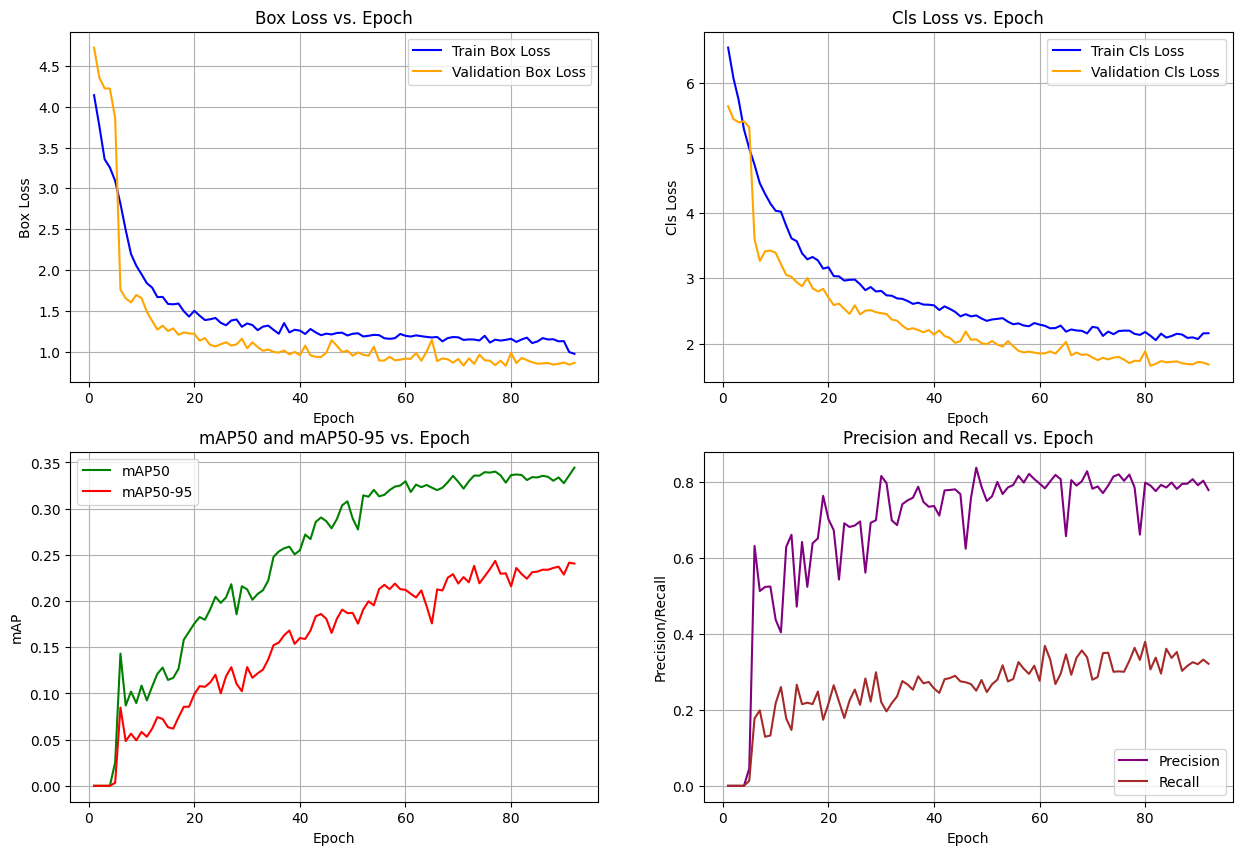

In [5]:

results = pd.read_csv("C:/Users/ASUS/Desktop/Projet2_JY/runs/detect/yolov8n_final_cpu9/results.csv")
plt.figure(figsize=(15, 10))

# 1. Box Loss (Train vs Validation)
plt.subplot(2, 2, 1)
plt.plot(results['epoch'], results['train/box_loss'], label='Train Box Loss', color='blue')
plt.plot(results['epoch'], results['val/box_loss'], label='Validation Box Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Box Loss')
plt.title('Box Loss vs. Epoch')
plt.legend()
plt.grid(True)

# 2. Cls Loss (Train vs Validation)
plt.subplot(2, 2, 2)
plt.plot(results['epoch'], results['train/cls_loss'], label='Train Cls Loss', color='blue')
plt.plot(results['epoch'], results['val/cls_loss'], label='Validation Cls Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Cls Loss')
plt.title('Cls Loss vs. Epoch')
plt.legend()
plt.grid(True)

# 3. mAP50 و mAP50-95
plt.subplot(2, 2, 3)
plt.plot(results['epoch'], results['metrics/mAP50(B)'], label='mAP50', color='green')
plt.plot(results['epoch'], results['metrics/mAP50-95(B)'], label='mAP50-95', color='red')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('mAP50 and mAP50-95 vs. Epoch')
plt.legend()
plt.grid(True)

# 4. Precision و Recall
plt.subplot(2, 2, 4)
plt.plot(results['epoch'], results['metrics/precision(B)'], label='Precision', color='purple')
plt.plot(results['epoch'], results['metrics/recall(B)'], label='Recall', color='brown')
plt.xlabel('Epoch')
plt.ylabel('Precision/Recall')
plt.title('Precision and Recall vs. Epoch')
plt.legend()
plt.grid(True)


print("Learning curves saved as 'learning_curves.png'")

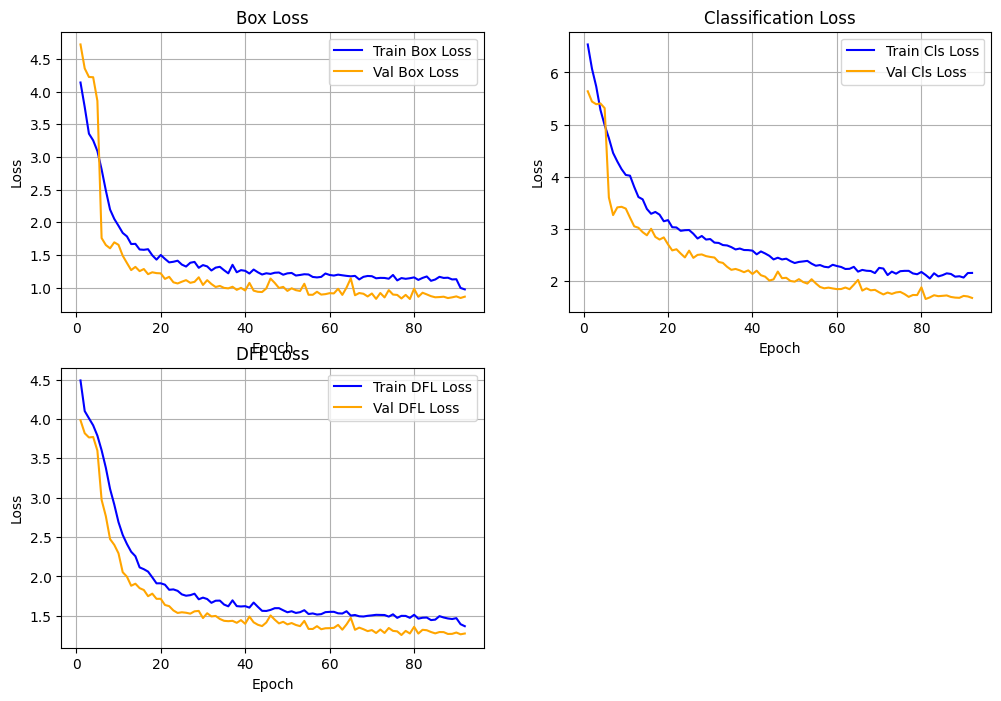

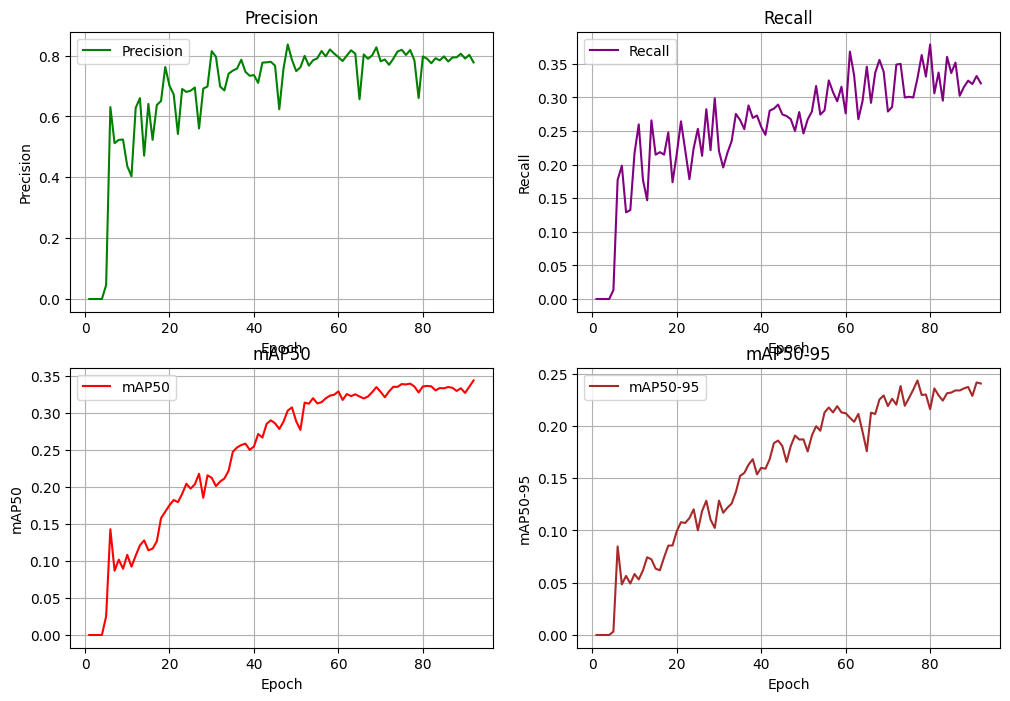

In [11]:
results_path = "C:/Users/ASUS/Desktop/Projet2_JY/runs/detect/yolov8n_final_cpu9/results.csv"
df = pd.read_csv(results_path)
df.columns = df.columns.str.strip()
plt.figure(figsize=(12, 8))

# Box Loss
plt.subplot(2, 2, 1)
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', color='blue')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss', color='orange')
plt.title('Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Cls Loss
plt.subplot(2, 2, 2)
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss', color='blue')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss', color='orange')
plt.title('Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# DFL Loss
plt.subplot(2, 2, 3)
plt.plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss', color='blue')
plt.plot(df['epoch'], df['val/dfl_loss'], label='Val DFL Loss', color='orange')
plt.title('DFL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)



# Plot Metrics (Precision, Recall, mAP)
plt.figure(figsize=(12, 8))

# Precision
plt.subplot(2, 2, 1)
plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision', color='green')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# Recall
plt.subplot(2, 2, 2)
plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall', color='purple')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

# mAP50
plt.subplot(2, 2, 3)
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50', color='red')
plt.title('mAP50')
plt.xlabel('Epoch')
plt.ylabel('mAP50')
plt.legend()
plt.grid(True)

# mAP50-95
plt.subplot(2, 2, 4)
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP50-95', color='brown')
plt.title('mAP50-95')
plt.xlabel('Epoch')
plt.ylabel('mAP50-95')
plt.legend()
plt.grid(True)



# Test model

Ultralytics 8.3.149  Python-3.9.21 torch-2.7.0+cpu CPU (Intel Core(TM) i5-7200U 2.50GHz)
YOLOv8n summary (fused): 72 layers, 3,008,378 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.20.1 ms, read: 1171.5166.0 MB/s, size: 2449.8 KB)


val: Scanning D:\Project2\Project_Dataset\yolo_dataset(1)\test\labels.cache... 69 images, 0 backgrounds, 0 corrupt: 100
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:29<0


                   all         69        107      0.881      0.358      0.418      0.301
              artifact          6          8          1          0     0.0384     0.0191
                  band          1          1          1          0      0.142      0.128
                 blast         12         13      0.726      0.846      0.801        0.4
           large lymph         11         11      0.849      0.909      0.936      0.744
              monocyte          7          7      0.615      0.143      0.377       0.29
            neutrophil         52         62      0.861      0.968      0.957      0.751
           small lymph          2          2          1          0     0.0798     0.0739
                 unknn          3          3          1          0     0.0105    0.00398
Speed: 4.1ms preprocess, 152.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to C:\Users\ASUS\Desktop\Projet2_JY\runs\detect\yolov8n_final_cpu9\test_results\test7
Test Results:
M

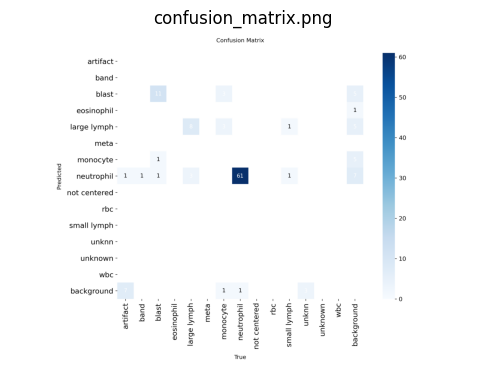

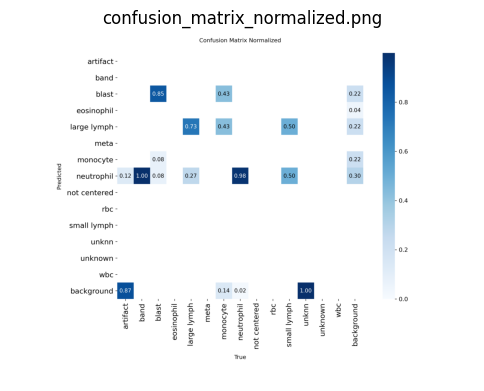

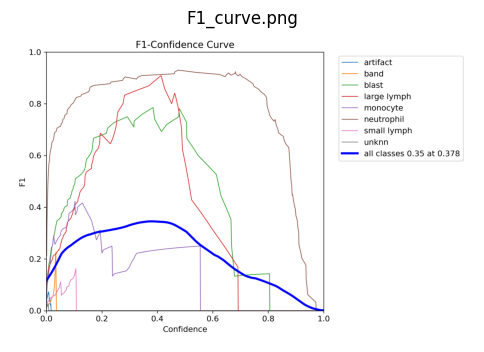

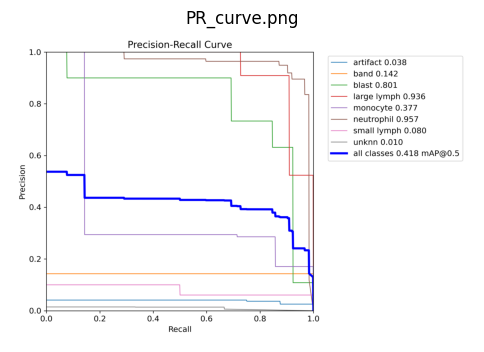

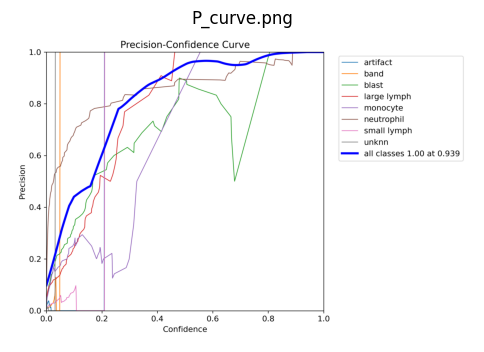

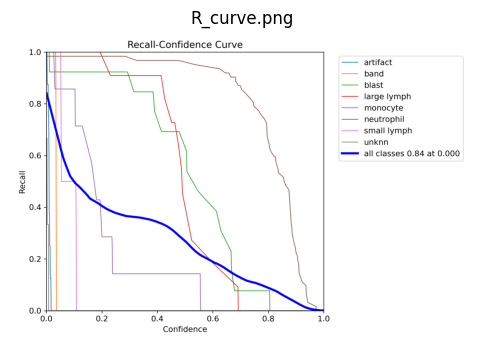

📁 Test results and plots saved in: C:/Users/ASUS/Desktop/Projet2_JY/runs/detect/yolov8n_final_cpu9/test_results\test


In [6]:
model_path = "C:/Users/ASUS/Desktop/Projet2_JY/runs/detect/yolov8n_final_cpu9/weights/best.pt"  
data_yaml = "D:/Project2/Project_Dataset/yolo_dataset(1)/data.yaml" 
output_dir = "C:/Users/ASUS/Desktop/Projet2_JY/runs/detect/yolov8n_final_cpu9/test_results"
os.makedirs(output_dir, exist_ok=True)
model = YOLO(model_path)

results = model.val(
    data=data_yaml,          
    split="test",           
    imgsz=640,              
    batch=16,               
    conf=0.001,             
    iou=0.6,                
    project=output_dir,     
    name="test",            
    save=True,              
    save_txt=True,          
    save_conf=True,         
    plots=True             
)
print("Test Results:")
print(f"Mean Precision: {results.box.mp:.4f}")
print(f"Mean Recall: {results.box.mr:.4f}")
print(f"Mean mAP50: {results.box.map50:.4f}")
print(f"Mean mAP50-95: {results.box.map:.4f}")

with open(os.path.join(output_dir, "test_metrics.txt"), "w") as f:
    f.write(f"Mean Precision: {results.box.mp:.4f}\n")
    f.write(f"Mean Recall: {results.box.mr:.4f}\n")
    f.write(f"Mean mAP50: {results.box.map50:.4f}\n")
    f.write(f"Mean mAP50-95: {results.box.map:.4f}\n")

    %matplotlib inline
plot_images = glob.glob(os.path.join(plots_folder, "*.png"))
for img_path in plot_images:
    img = Image.open(img_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(os.path.basename(img_path))
    plt.show()

print(f"📁 Test results and plots saved in: {plots_folder}")